In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    RocCurveDisplay, precision_recall_fscore_support
)

RANDOM_STATE = 42

df = pd.read_csv("diabetes_binary_5050split_health_indicators_BRFSS2015.csv")

# Target & features
TARGET = "Diabetes_binary"
X = df.drop(columns=[TARGET])
y = df[TARGET].astype(int)

# Train/validation split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)

def evaluate(model, X_test, y_test, name="Model"):
    """Prints core metrics and returns a dict for logging/aggregation."""
    y_pred = model.predict(X_test)
    # For binary problems we can compute ROC-AUC on probabilities:
    try:
        y_proba = model.predict_proba(X_test)[:, 1]
        auc = roc_auc_score(y_test, y_proba)
    except Exception:
        auc = np.nan

    print(f"\n{name} — Classification report")
    print(classification_report(y_test, y_pred, digits=4))
    print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))
    if not np.isnan(auc):
        print(f"ROC-AUC: {auc:.4f}")

    return {
        "model": name,
        "roc_auc": auc,
        **{
            f"f1_{label}": f1
            for label, f1 in zip(
                sorted(np.unique(y_test)),
                precision_recall_fscore_support(y_test, y_pred, average=None)[2]
            )
        }
    }

In [2]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=400,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=RANDOM_STATE,
    n_jobs=-1
)
rf.fit(X_train, y_train)
rf_metrics = evaluate(rf, X_test, y_test, "Random Forest")

# Feature importance
importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
print("\nTop 10 Feature Importances (RF):\n", importances.head(10))



Random Forest — Classification report
              precision    recall  f1-score   support

           0     0.7584    0.6986    0.7273      7070
           1     0.7206    0.7775    0.7480      7069

    accuracy                         0.7380     14139
   macro avg     0.7395    0.7380    0.7376     14139
weighted avg     0.7395    0.7380    0.7376     14139

Confusion matrix:
 [[4939 2131]
 [1573 5496]]
ROC-AUC: 0.8129

Top 10 Feature Importances (RF):
 BMI          0.169878
Age          0.126309
GenHlth      0.109393
Income       0.083779
HighBP       0.074999
PhysHlth     0.068565
Education    0.057806
MentHlth     0.051255
HighChol     0.040477
Fruits       0.028560
dtype: float64


In [3]:
param_grid = {
    "n_estimators": [200, 400, 800],
    "max_depth": [None, 10, 20, 40],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 5]
}
grid_rf = GridSearchCV(RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1),
                       param_grid, scoring="f1_macro", cv=5, n_jobs=-1)
grid_rf.fit(X_train, y_train)
best_rf = grid_rf.best_estimator_
evaluate(best_rf, X_test, y_test, "Random Forest (Tuned)")


Random Forest (Tuned) — Classification report
              precision    recall  f1-score   support

           0     0.7750    0.7030    0.7372      7070
           1     0.7282    0.7959    0.7605      7069

    accuracy                         0.7494     14139
   macro avg     0.7516    0.7494    0.7489     14139
weighted avg     0.7516    0.7494    0.7489     14139

Confusion matrix:
 [[4970 2100]
 [1443 5626]]
ROC-AUC: 0.8274


{'model': 'Random Forest (Tuned)',
 'roc_auc': 0.8274220789498065,
 'f1_0': 0.7372246532670771,
 'f1_1': 0.7605272051368706}

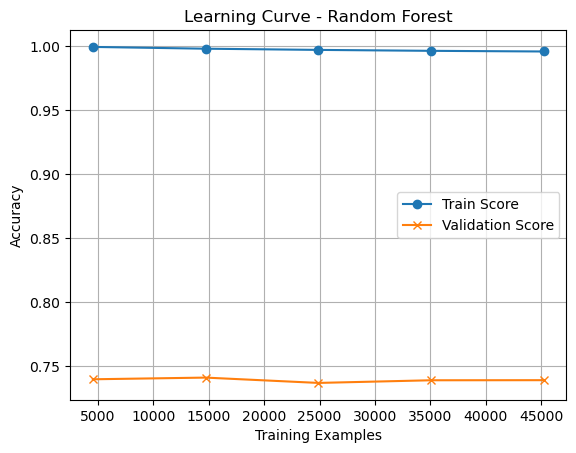

In [9]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(rf, X_train, y_train, cv=5)

train_mean = train_scores.mean(axis=1)
test_mean = test_scores.mean(axis=1)

plt.plot(train_sizes, train_mean, label="Train Score", marker='o')
plt.plot(train_sizes, test_mean, label="Validation Score", marker='x')
plt.title("Learning Curve - Random Forest")
plt.xlabel("Training Examples")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

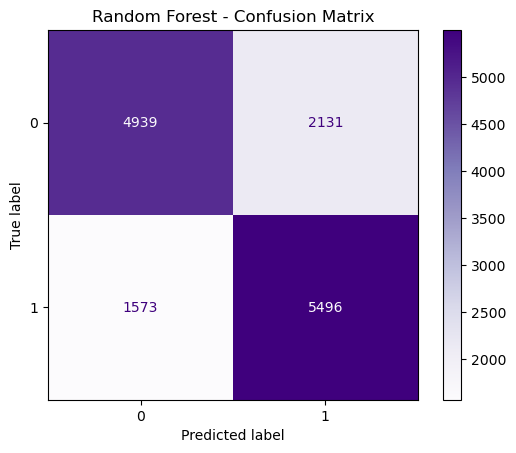

In [11]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, rf.predict(X_test))
ConfusionMatrixDisplay(cm).plot(cmap='Purples')
plt.title("Random Forest - Confusion Matrix")
plt.show()


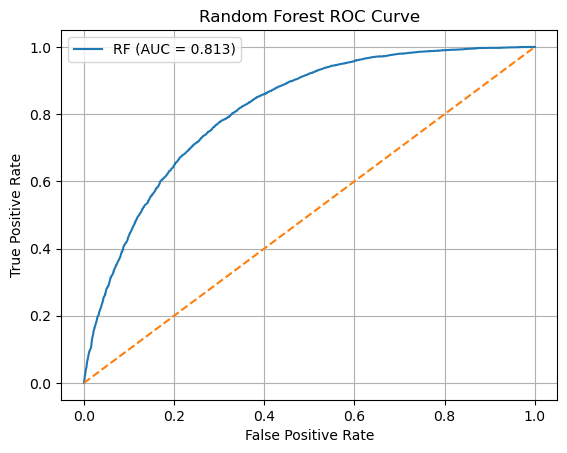

In [13]:
from sklearn.metrics import roc_curve, auc

y_prob = rf.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f"RF (AUC = {roc_auc:.3f})")
plt.plot([0,1],[0,1],'--')
plt.title("Random Forest ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()


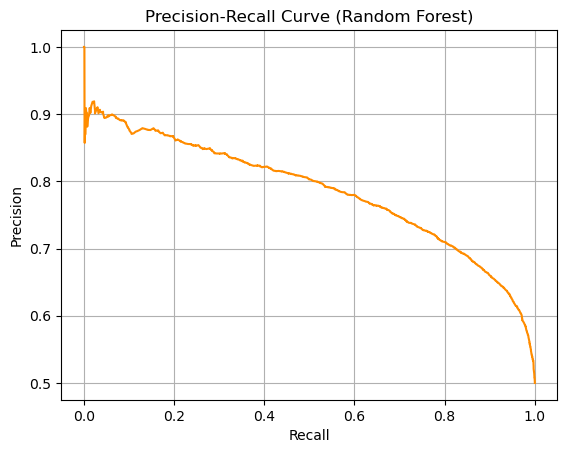

In [15]:
from sklearn.metrics import precision_recall_curve

precision, recall, _ = precision_recall_curve(y_test, y_prob)
plt.plot(recall, precision, color='darkorange')
plt.title("Precision-Recall Curve (Random Forest)")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid(True)
plt.show()


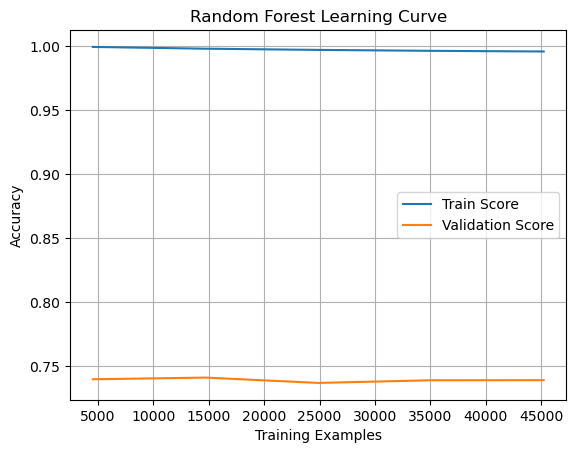

In [17]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(rf, X_train, y_train, cv=5)
train_mean = train_scores.mean(axis=1)
test_mean = test_scores.mean(axis=1)

plt.plot(train_sizes, train_mean, label="Train Score")
plt.plot(train_sizes, test_mean, label="Validation Score")
plt.title("Random Forest Learning Curve")
plt.xlabel("Training Examples")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()


100%|===================| 28277/28278 [949:28<00:02]          

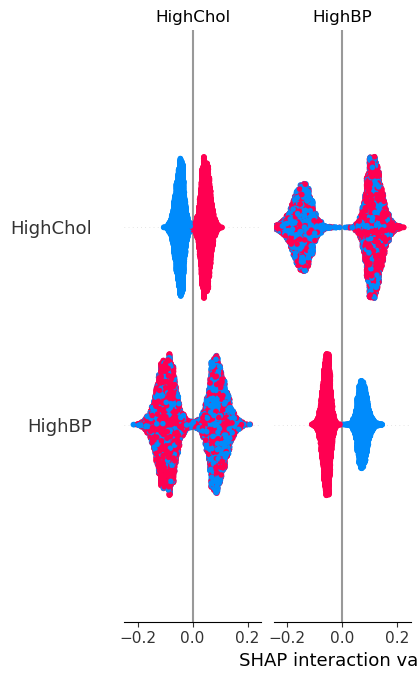

In [19]:
import shap

explainer = shap.Explainer(rf, X_train)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test)
